In [1]:
import nltk
from nltk.tokenize import word_tokenize
import itertools
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import words
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
import sys, traceback


In [2]:
## AnalyticsVidhya
#https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy
import csv

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [3]:
import pandas as pd
import numpy as np
import os
import re
import spacy
from spacy import displacy
from textblob import Word
import gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
import pyLDAvis
import pyLDAvis.gensim
from sklearn.feature_extraction.text import TfidfVectorizer


In [4]:
#Kaggle, https://www.kaggle.com/akashram/topic-modeling-intro-implementation

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [5]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()


Loading BokehJS ...

In [6]:
#Environment settings
warnings.filterwarnings('ignore')

%matplotlib inline
# %load_ext memory_profiler

In [7]:
#Installation needed
# !pip install nltk
# !pip install wordnet
# !pip install gensim
# !pip install google-compute-engine
# !pip install pyLDAvis
# !python3 -m spacy download en

In [8]:
#Download needed
# nltk.download('wordnet')


# Reading tsv files

In [9]:
#Limiting the number of files read due to system resource limitation
#Noticed that some of the files are throwing a format error . Examples: 154892.tsv, 193037.tsv

In [17]:
#Replaced single and double quotes with space
#! sh replace_pattern.sh 

In [7]:
DIR_SAVED='./saved'
FILENAME='df_raw_just_loaded.pkl'


In [5]:
#4.5 hours to load and pickle
LOAD_FILES=False

if LOAD_FILES:
    print("============== Started loading files ===================")
    df_raw=pd.DataFrame(columns=['filename','message','first_question','usernames'])
    NUM_FILES_READ=3000
    path='./dialogs_mod/4'
    for subdir, dirs, files in os.walk(path):
    #     for file in files[:NUM_FILES_READ]:
    #         print("file:",file)
        for file in files:
            if file.endswith((".tsv")):
                try:
                    print("Starting "+subdir+'/'+file)
                    df_file = pd.read_csv(subdir+'/'+file,header=None,names=['ts','from','to','message'],sep='\t')
                    df_file['message'] = df_file['message'].fillna(' ')
                    dict_file = {}
                    dict_file['filename']=file
                    dict_file['first_question']=df_file['message'][0]
                    dict_file['message']='. '.join(list(df_file['message']))
                    from_user=list(df_file['from'])
                    dict_file['usernames']=set(from_user)
        #           TODO: Include repliers 
                    df_raw=pd.concat([df_raw,pd.DataFrame.from_dict([dict_file])], sort=False, ignore_index=True)
                except:
                    print("An exception occurred at ",file)
                    print("-"*60)
                    traceback.print_exc(file=sys.stdout)
                    print("-"*60)
    print("============== Started saving to pickle files ===================")
    df_raw.to_pickle(DIR_SAVED+'/'+FILENAME)
else:
    print("============== Skipped loading files ===================")



============== Skipped loading files ===================


In [7]:
DIR_SAVED='./saved'
FILENAME='df_raw_just_loaded.pkl'


In [8]:
df_raw = pd.read_pickle(DIR_SAVED+'/'+FILENAME)
print(type(df_raw))
print(df_raw.shape)
print(df_raw.columns)


<class 'pandas.core.frame.DataFrame'>
(269023, 4)
Index(['filename', 'message', 'first_question', 'usernames'], dtype='object')


In [13]:
#Checking for NULL
df_raw['message'].isnull().sum()

0

In [10]:
df_raw['num_words_raw'] = df_raw['message'].apply(lambda x : len(x.split()))

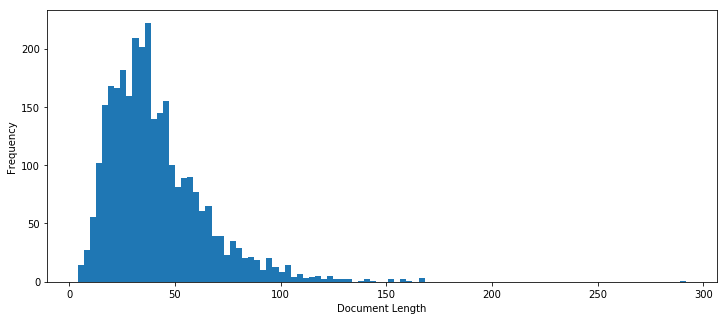

In [9]:
doc_lengths = df_raw['num_words_raw'].values
plt.figure(figsize=(12,5))
plt.hist(doc_lengths, bins=100)
# plt.xlim((0,40000))
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()


In [14]:
# examing the document length 
print("Average document length: {} words".format(round(np.mean(df_raw['num_words_raw']))))
print("Median document length: {} words".format(round(np.median(df_raw['num_words_raw']))))
print("Max document length: {} words".format(round(np.max(df_raw['num_words_raw']))))
print("Min document length: {} words".format(round(np.min(df_raw['num_words_raw']))))


Average document length: 42.0 words
Median document length: 37.0 words
Max document length: 344 words
Min document length: 4 words


In [15]:

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,200], bins=20, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    bp.output_file("hist.html")
    bp.show(fig)


In [16]:
    
plot_length_histogram(doc_lengths)

NameError: name 'doc_lengths' is not defined

# Usernames

In [17]:
#Listing all username for stop words
all_usernames=set()
for list1 in df_raw['usernames']:
    for list2 in list1:
        all_usernames.add(list2)


# Stop words

In [20]:
# stop = list(set(nltk.corpus.stopwords.words('english') + list(gensim.parsing.preprocessing.STOPWORDS)))
stop = nltk.corpus.stopwords.words('english')
print(len(stop))
additional_stop_words=['yes','no','ubuntu','linux','help','thanks','thank','work','support','error','problem','file',
                       'installed','install','installing','software']
additional_stop_words=['ubuntu','linux']
stop = stop + additional_stop_words
print(len(stop))
stop = stop + list(set(all_usernames))
print(len(stop))


179
181
140718


# Spacy

In [21]:
nlp_spacy = spacy.load("en_core_web_sm") 


# Preprocess

In [22]:
def f_preprocess_1(in_raw_msg):
    """
    Removes punctuation, stop words, digits, and domain names. Also lemmatizes and filters by certain pos tags 
    
    Input:
    ----------
    in_raw_msg : Unaltered complete message for a file

    Returns:
    -------
    Processed and tokenized messge
    """
    
    global all_usernames
    global lemmatizer 
    global stop
    result = in_raw_msg

    #lowercasing
    result = " ".join(x.lower() for x in result.split())
    
    #removing domain names
    pattern = r"[^\s]*\.(com|org|net)\S*"
    result = re.sub(pattern, '', result)
    pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    result = re.sub(pattern, '', result)
    pattern = r"www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    result = re.sub(pattern, '', result)

    #Removing punctuation
    result = re.sub('[^A-Za-z]+', ' ', result)
#     result = re.sub(r'[?]+', " ", result)  
#     result = re.sub(r'[ ]+\.', ".", result)  
#     result = re.sub(' --', '', result)
#     result = re.sub('[-_]+', '', result)
#     result = re.sub('[(]+', '', result)
#     result = re.sub('[)]+', '', result)
#     result = re.sub('[;]+', '', result)
#     result = re.sub('[\"]+', '', result)
#     #replacing dots(.)
#     result = re.sub('[\.]+', ' ', result)
#     #replacing screens/options with screens options
#     result = re.sub('[/]+', ' ', result)
#     #replacing i'm with im
#     result = re.sub('[\']+', '', result)
#     result = result.replace("!@#$%^&*()[]{};:,./<>?|`~-=_+", " ")  
#     result = re.sub(r'[!@#$%^&*()[]{};:,./<>?|`~-=_+]*', " ", result)  

    #Remove digits
    #result = re.sub(r"\d+", "", result)

    #Removing stop words
    result = ' '.join([word for word in result.split() if word not in stop])
    result = result.replace(r'\s+','')

    # Lemmatization: converts the word into its root word, rather than just stripping the suffices.
    # Going with spacy instead of nltk due to better output
    doc = nlp_spacy(result) 
    tmp_result=[]
    for token in doc: 
        tmp_result.append(token.lemma_) 
        #tmp_result.append(token.orth_) 
    result = ' '.join(tmp_result)
#     print("Lemma: ",result,"\n")
    

    #replacing multiple spaces with one
    result = re.sub('[ ]{2,}', ' ', result)
#     print("Multiple: ",result,"\n")

    #Considering words of length ge 2 and valid pos tags only
    
    result_valid=list()
    
    for (word,tag) in nltk.pos_tag(word_tokenize(result)):
        if len(word)>=2:
            result_valid.append(word)  

    result = ' '.join(result_valid)
#     print("Final: ",result,"\n")
    

    return result

In [23]:
# message_processed to hold the cleaned data
# 9 hours
df_raw['message_processed'] = df_raw['message'].apply(f_preprocess_1)


In [24]:
SAVE_TO_PICKLE=True
DIR_SAVED='./saved'
FILENAME_V2='df_raw_V2.pkl'

if SAVE_TO_PICKLE:
    df_raw.to_pickle(DIR_SAVED+'/'+FILENAME_V2)
else:
    print("======= Skipping SAVE_TO_PICKLE ===========")


In [8]:
LOAD_FROM_PICKLE=True


if LOAD_FROM_PICKLE:
    SAVE_TO_PICKLE=True
    DIR_SAVED='./saved'
    FILENAME_V2='df_raw_V2.pkl'
    
    df_raw = pd.read_pickle(DIR_SAVED+'/'+FILENAME_V2)
    print(type(df_raw))
    print(df_raw.shape)
    print(df_raw.columns)
else:
    print("======= Skipping LOAD_FROM_PICKLE ===========")



<class 'pandas.core.frame.DataFrame'>
(269023, 6)
Index(['filename', 'message', 'first_question', 'usernames', 'num_words_raw',
       'message_processed'],
      dtype='object')


In [136]:
df_raw[['message']].head(1).values[0][0]

'hello there. I am trying to install GLX on my Dapper (ATI 9200 mobile; IBM T42 laptop). I am following the guide that is on the Ubuntuforum.org, but it does not work as described. Who is willing to help me?. i think i didn\'t have to do anything except change driver from xorg.conf from ati to fglrx. The forum tells me: "Start gconf-editor and go to "apps/compiz/general/all screens/options"", but there is no section "apps/compiz" in gconf. I always use the fglrx driver, but there is some other strange problem'

In [144]:
df_raw['message_processed'].head(1)

0    hello try install glx dapper ati mobile ibm laptop follow guide work describe willing help think anything except change driver xorg conf ati fglrx forum tell start gconf editor go app compiz gener...
Name: message_processed, dtype: object

In [31]:
# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,200], bins=20, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    bp.output_file("hist.html")
    bp.show(fig)


# Analyzing length of processed messages

In [9]:
df_raw['num_words_processed'] = df_raw['message_processed'].apply(lambda string: len(string.split()))

In [10]:
# examing the document length 
print("Average message length: {} words".format(round(np.mean(df_raw['num_words_processed']))))
print("Median message length: {} words".format(round(np.median(df_raw['num_words_processed']))))
print("Max message length: {} words".format(round(np.max(df_raw['num_words_processed']))))
print("Min message length: {} words".format(round(np.min(df_raw['num_words_processed']))))


Average message length: 15.0 words
Median message length: 13.0 words
Max message length: 203 words
Min message length: 0 words


In [14]:
df_raw[df_raw['num_words_processed']==0]

,filename,message,first_question,usernames,num_words_raw,message_processed,num_words_processed
321,186965.tsv,So.... Anyone>. *?. anyone what?,So...,"{arch_is_awesome, ikonia}",5,,0
479,10077.tsv,hey guys. anyone home?. hi. hello?,hey guys,"{lenswipe, MATAH}",6,,0
1055,16411.tsv,quit. help. help. what s up?,quit,"{rio_, [snake]}",6,,0
1492,77108.tsv,here s mine: http://i270.photobucket.com/albums/jj93/andrew_woodhead666/desktop.jpg?t=1231760517. - no no.. lol. ?. its fluxbox,here s mine: http://i270.photobucket.com/albums/jj93/andrew_woodhead666/desktop.jpg?t=1231760517,"{ActionParsnip, KeithGS}",11,,0
2336,82086.tsv,"怎么没人说话啊. 谢谢. 哦 原来如此. ??????????,?????????? ???",怎么没人说话啊,"{Saiki, joerh99}",6,,0
3338,101390.tsv,i am who i am because of who we all are. :o. namaste. *g*,i am who i am because of who we all are,"{mojo, sagredo}",14,,0
4235,181156.tsv,m z z: : w h a t s u t f 1 6 ?. l o m p f o n g : y o u r t e x t i s n t s p a c e d. m z z : i a m o n b r e e z y b a d g e r. y o u s h o u l d u s e t a b c o m p l e t e,m z z: : w h a t s u t f 1 6 ?,"{jifli, bruenig}",86,,0
5123,252932.tsv,"hi!. list!. 1, 2, 3, 4. 5",hi!,"{reisio, alessandro97}",7,,0
5695,92421.tsv,p. ?????. i from china. I m not ^^,p,"{sergiu_, fengxiaoxiao}",9,,0
6550,119561.tsv,hi. heyy. hey guys. support question?,hi,"{wafiiq_, bazhang}",6,,0


In [11]:
#Saving records to be discarded
df_processed_1 = df_raw[df_raw['num_words_processed']>10]
df_processed_1.shape

(170145, 7)

In [12]:
# examing the document length 
print("Average message length: {} words".format(round(np.mean(df_processed_1['num_words_processed']))))
print("Median message length: {} words".format(round(np.median(df_processed_1['num_words_processed']))))
print("Max message length: {} words".format(round(np.max(df_processed_1['num_words_processed']))))
print("Min message length: {} words".format(round(np.min(df_processed_1['num_words_processed']))))


Average message length: 19.0 words
Median message length: 17.0 words
Max message length: 203 words
Min message length: 11 words


In [14]:
df_raw['num_words_changed'] = df_raw['num_words_raw'] - df_raw['num_words_processed']

In [ ]:
df_raw[df_raw['num_words_changed']>0].sort_values(['num_words_changed'], ascending=[0])\
[['num_words_changed','filename','message','message_processed']].head(2)
                                                                           

# Document frequency

In [79]:
# from collections import defaultdict

# def f_document_word_frequency(in_record):
#     DF = defaultdict(int) 
#     print(in_record)
        

In [174]:
# from collections import defaultdict
# DF = defaultdict(int) 
# for list_words in df_processed_1['message_processed'].str.split():
#     for word in set(list_words):
#         DF[word] += 1

In [95]:
# df_raw.shape[0]

2706

In [ ]:
# for word in sorted(DF, key=DF.get, reverse=True):
#     print(word, DF[word])


In [295]:
# THRESHOLD_FREQ_WORDS_TO_ELIMINATE=500
# frequent_words = []
# for word, count in DF.items():
#     if count>=THRESHOLD_FREQ_WORDS_TO_ELIMINATE:
#         frequent_words.append(word)
# print(frequent_words)


['try', 'use', 'get']


In [ ]:
#Number of documents the word occurs in
# THRESHOLD_RARE_WORDS_TO_ELIMINATE=5
# rare_words = []
# for word, count in DF.items():
#     if count<=THRESHOLD_RARE_WORDS_TO_ELIMINATE:
#         rare_words.append(word)
# print(rare_words)


In [296]:
# def f_preprocess_2(in_message):
#     global frequent_words 
#     result = in_message
#     tmp_result =[]
#     for word in result.split():
#         if word not in frequent_words:
#             tmp_result.append(word)
    
#     result = tmp_result
#     return result


In [297]:
# df_processed_1['message_no_frequent_split'] = df_processed_1['message_processed'].apply(f_preprocess_2)
                                                                                  
                                                                                  

# Build BTM model

In [17]:
import biterm
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM


In [16]:
df_processed_2 = df_processed_1.sample(n=100)

In [19]:
df_processed_2.shape[0]

100

In [21]:
df_processed_2.head()

,filename,message,first_question,usernames,num_words_raw,message_processed,num_words_processed
32422,113844.tsv,Would anyone here happen to know why a static network IP wouldn t work?. Or the network settings may be for a different subnet.. I m the only one on the network right now and also my static IP isn...,Would anyone here happen to know why a static network IP wouldn t work?,"{MoreAllLess, Slynderdale}",55,would happen know static network ip network setting may subnet network right also static ip communicate,16
199268,234925.tsv,"the command is umount. and you have to do it in sudo. sounds like you attempted to start punmount, a script that requires root access when you really wanted to start umount. well right but maybe I...",the command is umount,"{marcin_ant, apollo2011}",50,command umount sound attempt start punmount script require access really start umount right add something etc fstab enable user sudoer,20
66034,228878.tsv,"... yes nn... absolutely. with sarcasm , the thing is , you never know where it stops. ok, I ve kinda fucked up my ubuntu, did a chown -hR in the root directory and now a regular not-root user can...",... yes nn... absolutely,"{ailean, packagedeliverer}",48,absolutely know stop kinda fuck chown hr directory regular anymore watch language,12
133269,58994.tsv,"every time i reboot the contents of /proc/sys/net/ipv6/conf/all/disable_ipv6 is reverted to 0,....... how can i change this?. it s compiled into the kernel. for some weird reason. But there is no ...","every time i reboot the contents of /proc/sys/net/ipv6/conf/all/disable_ipv6 is reverted to 0,....... how can i change this?","{loomsen1, BlackDex}",35,every time reboot content proc ipv conf disable ipv revert compile weird configure,13
22453,28988.tsv,"Hi, im new to ubuntu/linux, im installing ubuntu on my notebook using virtualbox and right know im using wireless, it is going to be a problem or i need to configure something if i want to access ...","Hi, im new to ubuntu/linux, im installing ubuntu on my notebook using virtualbox and right know im using wireless, it is going to be a problem or i need to configure something if i want to access ...","{ploks, ZykoticK9}",83,instal notebook use virtualbox right know use go problem configure something want access cable conencte know get network virtualbox thank aboout install depend many factor,25


In [26]:
df_processed_2.reset_index()
df_processed_2.index = range(0,df_processed_2.shape[0])


In [27]:
vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(df_processed_2.message_processed).toarray()


In [28]:
vocab = np.array(vec.get_feature_names())
biterms = vec_to_biterms(X)


In [29]:
btm = oBTM(num_topics=20, V=vocab)
topics = btm.fit_transform(biterms, iterations=100)


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


In [30]:
df_processed_2.loc[50].message_processed

'know network adapter driver talk get nice card work bcmfirmware use ndiswrapper'

In [31]:
topics[0].argmax()

10

In [32]:
vis = pyLDAvis.prepare(btm.phi_wz.T, topics, np.count_nonzero(X, axis=1), vocab, np.sum(X, axis=0))
pyLDAvis.save_html(vis, './online_btm.html')


# LDA model

In [303]:
# Creating the object for LDA model using gensim library
# LDA = gensim.models.ldamodel.LdaModel

# # Build LDA model
# lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
#                 chunksize=3000, passes=50)


In [304]:
# Number of topics X Vocabulary
# lda_model.get_topics().shape

(5, 6756)

In [305]:
# lda_model.get_topic_terms(0)

[(40, 0.020701267),
 (23, 0.0150794005),
 (49, 0.011505394),
 (109, 0.011487447),
 (634, 0.010499926),
 (35, 0.010408781),
 (200, 0.0093411915),
 (37, 0.008784741),
 (429, 0.008227871),
 (94, 0.007818473)]

In [306]:
# lda_model.print_topics()


[(0,
  '0.021*"apt" + 0.015*"install" + 0.012*"package" + 0.011*"not" + 0.010*"firefox" + 0.010*"work" + 0.009*"instal" + 0.009*"add" + 0.008*"source" + 0.008*"find"'),
 (1,
  '0.011*"window" + 0.009*"install" + 0.009*"work" + 0.008*"know" + 0.008*"like" + 0.008*"boot" + 0.008*"go" + 0.007*"not" + 0.007*"cd" + 0.007*"driver"'),
 (2,
  '0.017*"file" + 0.016*"install" + 0.011*"partition" + 0.010*"help" + 0.010*"know" + 0.009*"boot" + 0.009*"one" + 0.008*"not" + 0.008*"make" + 0.007*"root"'),
 (3,
  '0.013*"run" + 0.012*"gnome" + 0.012*"bit" + 0.009*"instal" + 0.009*"want" + 0.009*"one" + 0.007*"think" + 0.007*"question" + 0.007*"version" + 0.007*"work"'),
 (4,
  '0.013*"work" + 0.010*"help" + 0.008*"file" + 0.008*"need" + 0.008*"server" + 0.007*"run" + 0.007*"go" + 0.007*"thank" + 0.007*"dalton" + 0.006*"please"')]

In [307]:
# lda_model.get_document_topics(bow=doc_term_matrix[0], per_word_topics=False)

[(0, 0.3048624), (1, 0.36221012), (4, 0.32359302)]

In [310]:
lda_model.get_document_topics(bow=doc_term_matrix[1], per_word_topics=False)

[(0, 0.8082326), (1, 0.16977194)]

In [311]:
# print("=======RAW==============")
# print(df_processed_1['message'].head(1).values[0])
# print("=======PROCESSED==============")
# print(' '.join(df_processed_1['message_no_frequent_split'].head(1).values[0]))
# print("=======TOPIC==============")
# print(lda_model.print_topic(topicno=3, topn= 4))

=======RAW==============
hello there. I am trying to install GLX on my Dapper (ATI 9200 mobile; IBM T42 laptop). I am following the guide that is on the Ubuntuforum.org, but it does not work as described. Who is willing to help me?. i think i didn't have to do anything except change driver from xorg.conf from ati to fglrx. The forum tells me: "Start gconf-editor and go to "apps/compiz/general/all screens/options"", but there is no section "apps/compiz" in gconf. I always use the fglrx driver, but there is some other strange problem
=======PROCESSED==============
hello install glx dapper ati mobile ibm laptop follow guide work describe willing help think anything except change driver xorg conf ati fglrx forum tell start gconf editor go app compiz general screen option section app compiz gconf always fglrx driver strange problem
=======TOPIC==============
0.013*"run" + 0.012*"gnome" + 0.012*"bit" + 0.009*"instal"


In [255]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.077276  0.014532       1        1  19.583113
0      0.107298  0.030600       2        1  19.163965
3      0.062142 -0.060633       3        1  18.193031
5      0.058697 -0.059957       4        1  14.598568
1      0.032646  0.184563       5        1  13.831747
2     -0.068037 -0.161423       6        1   8.409318
4     -0.270021  0.052319       7        1   6.220258, topic_info=     Category        Freq         Term       Total  loglift  logprob
34    Default  224.000000          apt  224.000000  30.0000  30.0000
98    Default  215.000000    partition  215.000000  29.0000  29.0000
604   Default  131.000000      firefox  131.000000  28.0000  28.0000
80    Default  194.000000           cd  194.000000  27.0000  27.0000
43    Default  197.000000      package  197.000000  26.0000  26.0000
279   Default  117.000000          bit  117.000000  25.0000  25.0000
54    Default  142.000000        drive  142.000000  24.0000  24.0000
9     Default  161.000000       driver  161.000000  23.0000  23.0000
78    Default  242.000000         boot  242.000000  22.0000  22.0000
339   Default  113.000000         user  113.000000  21.0000  21.0000
780   Default  112.000000        mount  112.000000  20.0000  20.0000
101   Default  117.000000         root  117.000000  19.0000  19.0000
184   Default   95.000000          log   95.000000  18.0000  18.0000
24    Default  112.000000       screen  112.000000  17.0000  17.0000
205   Default  199.000000        gnome  199.000000  16.0000  16.0000
4066  Default   51.000000       dalton   51.000000  15.0000  15.0000
176   Default  170.000000      command  170.000000  14.0000  14.0000
924   Default   60.000000     password   60.000000  13.0000  13.0000
580   Default   78.000000       nvidia   78.000000  12.0000  12.0000
627   Default  135.000000      upgrade  135.000000  11.0000  11.0000
322   Default  147.000000         open  147.000000  10.0000  10.0000
30    Default   69.000000         xorg   69.000000   9.0000   9.0000
400   Default  110.000000       source  110.000000   8.0000   8.0000
649   Default   70.000000     wireless   70.000000   7.0000   7.0000
89    Default   83.000000         live   83.000000   6.0000   6.0000
273   Default  107.000000      network  107.000000   5.0000   5.0000
443   Default  116.000000         grub  116.000000   4.0000   4.0000
4     Default  153.000000       change  153.000000   3.0000   3.0000
392   Default  147.000000       server  147.000000   2.0000   2.0000
324   Default   88.000000         play   88.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
5749   Topic7    4.459005   clonezilla    5.207308   2.6222  -6.4755
4402   Topic7    4.453567       render    5.204083   2.6216  -6.4767
1902   Topic7    4.363327          gpg    5.111404   2.6191  -6.4972
2041   Topic7    4.362461  fingerprint    5.110827   2.6190  -6.4974
790    Topic7   20.089705      website   25.117043   2.5540  -4.9702
2219   Topic7    6.471504         thru    7.935377   2.5734  -6.1030
924    Topic7   39.521435     password   60.724258   2.3479  -4.2935
931    Topic7   24.033295         lock   38.469379   2.3069  -4.7909
2304   Topic7    6.055523       forgot    7.477535   2.5664  -6.1694
184    Topic7   48.776695          log   95.560898   2.1048  -4.0831
339    Topic7   56.147594         user  113.946976   2.0696  -3.9424
1011   Topic7    8.245852    yesterday   11.146236   2.4760  -5.8607
101    Topic7   49.678703         root  117.379013   1.9175  -4.0648
1169   Topic7   18.057451    installer   31.026505   2.2361  -5.0768
587    Topic7   20.492159      monitor   37.695972   2.1678  -4.9503
1441   Topic7    9.799305        group   14.517496   2.3843  -5.6881
1398   Topic7   13.244485        local   23.284254   2.2132  -5.3868
340    Topic7   11.699482          var   20.947990   2.1949  -5.5108
1407   Topic7   10.78

# Analytics Vidhya

In [60]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()


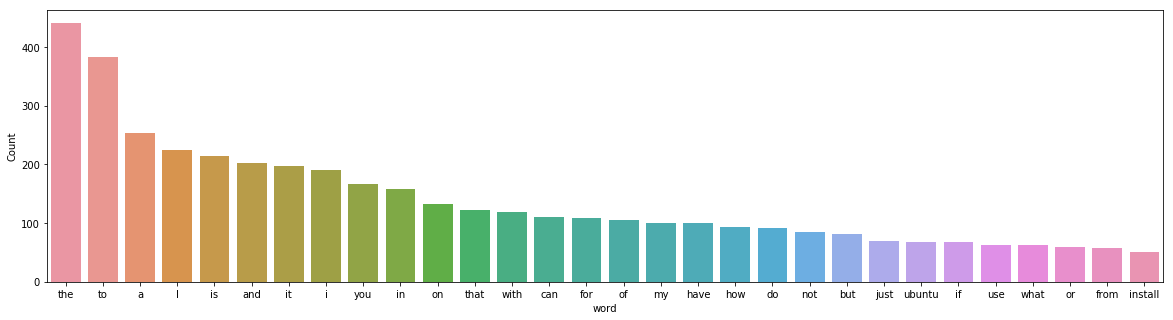

In [61]:
freq_words(df_raw['message'])


In [62]:
# remove unwanted characters, numbers and symbols
df_raw['reviewText'] = df_raw['message'].str.replace("[^a-zA-Z#]", " ")


In [63]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words = stop_words + ['ubuntu','linux']

In [64]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df_raw['reviewText'] = df_raw['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df_raw['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]


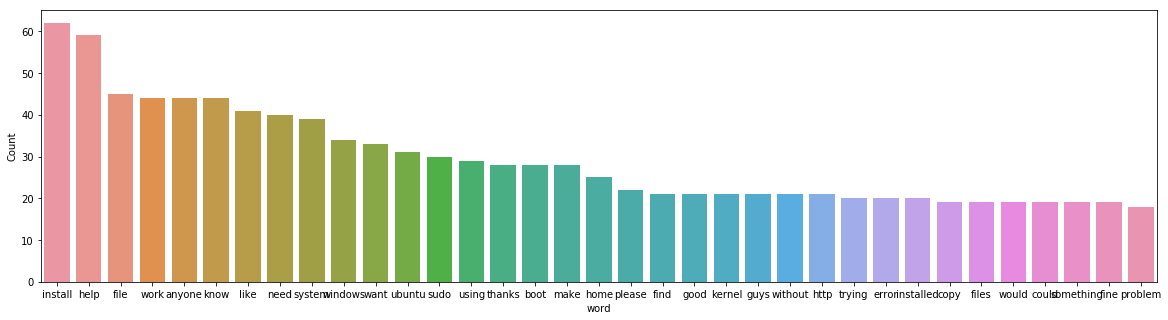

In [65]:
freq_words(reviews, 35)


In [66]:
#!python -m spacy download en # one time run


In [67]:
# To further remove noise from the text we can use lemmatization from the spaCy library. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output


In [68]:
# Let’s tokenize the reviews and then lemmatize the tokenized reviews.
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])



['curious', 'many', 'apps', 'installable', 'remove', 'apps', 'examples', 'remove', 'meant', 'noob', 'version', 'synaptic', 'want', 'packages', 'synaptic', 'system', 'admin', 'synaptic', 'thanks']


In [82]:
print(tokenized_reviews.shape)



(300,)


In [69]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review


['curious', 'many', 'app', 'installable', 'app', 'example', 'noob', 'version', 'synaptic', 'want', 'package', 'synaptic', 'system', 'admin', 'synaptic', 'thank']


In [84]:
print(len(reviews_2))


300


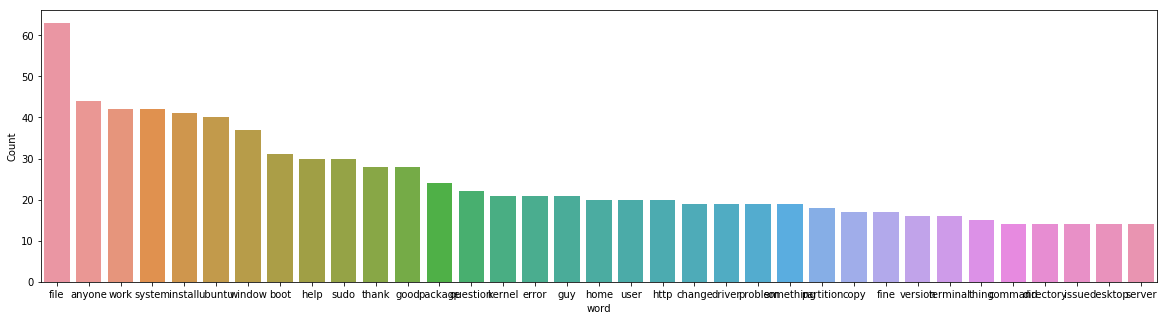

In [70]:
# As you can see, we have not just lemmatized the words but also filtered only nouns and adjectives. 
# Let’s de-tokenize the lemmatized reviews and plot the most common words.

reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df_raw['reviews'] = reviews_3

freq_words(df_raw['reviews'], 35)


In [71]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)


In [72]:
topics = lda_model.print_topics(num_words=3)
for topic in topics:
    print(topic)


(0, '0.032*"window" + 0.016*"file" + 0.014*"good"')
(1, '0.025*"work" + 0.015*"anyone" + 0.013*"compiz"')
(2, '0.013*"guy" + 0.011*"thank" + 0.011*"website"')
(3, '0.021*"file" + 0.015*"directory" + 0.011*"guy"')
(4, '0.023*"file" + 0.021*"ubuntu" + 0.018*"system"')
(5, '0.021*"boot" + 0.012*"anyone" + 0.011*"display"')
(6, '0.015*"package" + 0.013*"anyone" + 0.009*"install"')


In [73]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.121308  0.003067       1        1  28.947151
0      0.068593  0.014798       2        1  15.041587
5      0.044909 -0.156661       3        1  13.747130
3     -0.076289  0.060916       4        1  12.423074
6     -0.056978 -0.020180       5        1  10.502096
1      0.111784  0.085069       6        1  10.420680
2      0.029289  0.012990       7        1   8.918283, topic_info=     Category       Freq       Term      Total  loglift  logprob
168   Default  28.000000     window  28.000000  30.0000  30.0000
24    Default  31.000000       work  31.000000  29.0000  29.0000
59    Default  24.000000       boot  24.000000  28.0000  28.0000
78    Default  20.000000       good  20.000000  27.0000  27.0000
349   Default  15.000000        guy  15.000000  26.0000  26.0000
61    Default  49.000000       file  49.000000  25.0000  25.0000
149   Default  11.000000  directory  11.000000  24.0000  24.0000
412   Default  15.000000       http  15.000000  23.0000  23.0000
189   Default  10.000000   software  10.000000  22.0000  22.0000
3     Default   7.000000     compiz   7.000000  21.0000  21.0000
204   Default  11.000000    desktop  11.000000  20.0000  20.0000
40    Default   7.000000     device   7.000000  19.0000  19.0000
32    Default  18.000000    package  18.000000  18.0000  18.0000
57    Default  32.000000     ubuntu  32.000000  17.0000  17.0000
153   Default   7.000000       line   7.000000  16.0000  16.0000
93    Default   6.000000    display   6.000000  15.0000  15.0000
235   Default   9.000000    program   9.000000  14.0000  14.0000
14    Default  32.000000    install  32.000000  13.0000  13.0000
6     Default  15.000000     driver  15.000000  12.0000  12.0000
574   Default   5.000000    website   5.000000  11.0000  11.0000
481   Default  10.000000     people  10.000000  10.0000  10.0000
33    Default  10.000000   synaptic  10.000000   9.0000   9.0000
13    Default  23.000000       help  23.000000   8.0000   8.0000
673   Default   6.000000   password   6.000000   7.0000   7.0000
125   Default  17.000000   question  17.000000   6.0000   6.0000
575   Default   6.000000       well   6.000000   5.0000   5.0000
274   Default  11.000000      thing  11.000000   4.0000   4.0000
119   Default  17.000000      error  17.000000   3.0000   3.0000
675   Default   4.000000       josh   4.000000   2.0000   2.0000
74    Default  24.000000       sudo  24.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
153    Topic7   3.406755       line   7.735718   1.5970  -4.5533
673    Topic7   2.744761   password   6.190163   1.6038  -4.7694
1042   Topic7   1.419488        way   2.881891   1.7089  -5.4288
575    Topic7   2.744694       well   6.219770   1.5990  -4.7694
487    Topic7   3.156802    channel   7.944298   1.4942  -4.6295
165    Topic7   2.080446       need   4.854902   1.5697  -5.0465
349    Topic7   4.070563        guy  15.867337   1.0566  -4.3753
289    Topic7   2.082027     gksudo   6.032192   1.3533  -5.0458
952    Topic7   1.419639       menu   3.489179   1.5178  -5.4287
33     Topic7   2.744736   synaptic  10.005565   1.1236  -4.7694
481    Topic7   2.744984     people  10.168945   1.1075  -4.7693
412    Topic7   3.407030       http  15.161889   0.9241  -4.5533
274    Topic7   2.744620      thing  11.433761   0.9901  -4.7695
685    Topic7   2.082564  different   7.380154   1.1519  -5.0455
35     Topic7   3.644731      thank  21.301914   0.6516  -4.4858
219    Topic7   1.419555     search   4.199180   1.3325  -5.4288
186    Topic7   1.419807     answer   4.302855   1.3083  -5.4286
264    Topic7   2.082409      check   9.223318   0.9289  -5.0456
30     Topic7   2.174367       many  10.092743   0.8820  -5.0024
13     Topic7   3.002323       help  23.858435   0.3443  -4.6797
24     Topic7   2.744934       work  31.637154  -0.0275  -4.7693
6      Topic7   2.081876  

# MonkeyLearn
#https://monkeylearn.com/blog/introduction-to-topic-modeling/

In [74]:
#! curl -o "monkeylearn_reviews.csv" https://monkeylearn.com/blog/wp-content/uploads/2019/04/reviews.csv

In [75]:
reviews = [row for row in csv.reader(open('monkeylearn_reviews.csv'))]


In [76]:
reviews

[['Text', 'Sentiment', 'Topic'],
 ['The rooms are extremely small, practically only a bed.',
  'negative',
  'Comfort'],
 ['Room safe did not work.', 'negative', 'Facilities'],
 ['Mattress very comfortable.', 'positive', 'Comfort'],
 ['Very uncomfortable, thin mattress, with plastic cover that rustles every time you move.',
  'negative',
  'Comfort'],
 ['No bathroom in room', 'negative', 'Facilities'],
 ['The bed was soooo comfy.', 'positive', 'Comfort'],
 ['someone must have been smoking in the room next door.',
  'negative',
  'Cleanliness'],
 ['The bed is very comfortable.', 'positive', 'Comfort'],
 ['Very spacious rooms, quiet and very comfortable.', 'positive', 'Comfort'],
 ['For 3 people in a bedroom the sofa bed is a bit unconfortable.',
  'negative',
  'Comfort'],
 ['Lights in the common room were too dim.', 'negative', 'Facilities'],
 ['Air conditioning working fine.', 'positive', 'Comfort'],
 ["So if you're the type that likes to let water run a bit before getting wet or it t

In [77]:
texts = [row[0] for row in reviews]


In [85]:
texts

['Text',
 'The rooms are extremely small, practically only a bed.',
 'Room safe did not work.',
 'Mattress very comfortable.',
 'Very uncomfortable, thin mattress, with plastic cover that rustles every time you move.',
 'No bathroom in room',
 'The bed was soooo comfy.',
 'someone must have been smoking in the room next door.',
 'The bed is very comfortable.',
 'Very spacious rooms, quiet and very comfortable.',
 'For 3 people in a bedroom the sofa bed is a bit unconfortable.',
 'Lights in the common room were too dim.',
 'Air conditioning working fine.',
 "So if you're the type that likes to let water run a bit before getting wet or it takes a minute to figure out how to make it hot, you're gonna get wet.",
 'the windows are only single glazed so the heat could escape- although to be fair it was -6 outside!',
 'Terrible, small cubbyholes, which are marketed as rooms.',
 'Corridors filthy\nRoom filthy\nElectrical cables in room not safe\nWhole building smelly\nShower repulsive',
 'wall

In [86]:
stemmer = PorterStemmer()

def process_text(text):
    # Make all the strings lowercase and remove non alphabetic characters
    text = re.sub('[^A-Za-z]', ' ', text.lower())

    # Tokenize the text; this is, separate every sentence into a list of words
    # Since the text is already split into sentences you don't have to call sent_tokenize
    tokenized_text = word_tokenize(text)

    # Remove the stopwords and stem each word to its root
    clean_text = [
        stemmer.stem(word) for word in tokenized_text
        if word not in stopwords.words('english')
    ]

    # Remember, this final output is a list of words
    return clean_text

In [87]:
df_raw['ML_message_processed'] = df_raw['message'].apply(process_text)

In [88]:
df_raw['ML_message_processed']

0      [hello, tri, instal, glx, dapper, ati, mobil, ibm, laptop, follow, guid, ubuntuforum, org, work, describ, will, help, think, anyth, except, chang, driver, xorg, conf, ati, fglrx, forum, tell, star...
1                   [curiou, mani, app, instal, via, apt, get, add, remov, app, exampl, zsh, mpd, add, remov, meant, noob, version, synapt, want, gui, packag, use, synapt, system, admin, synapt, aha, thank]
2      [anyon, familar, digg, post, gutsi, feisti, overwork, harddriv, workaround, supposedli, set, advanc, power, manag, drive, hparm, b, devic, tri, set, drive, get, io, error, use, regular, ide, sata,...
3      [hey, someon, help, prob, mean, find, solut, prob, laptop, die, took, hdd, usb, hddcase, tri, copi, file, anoth, ubuntu, machin, machn, old, dont, boot, usb, permiss, copi, file, way, login, ubunt...
4      [slow, zsh, better, anyway, use, abl, work, wonder, zsh, gotten, lazi, feel, come, wrote, zsh, script, organ, music, cuz, renam, packag, xfce, segfault, one, time, h

In [89]:
#Dont run
##df_raw['ML_message_processed_2'] = df_raw['ML_message_processed'].apply(lambda x : [' '.join(x)])

In [90]:
ML_message_processed_3 = [text for text in df_raw['ML_message_processed']]

In [93]:
#TESTING
# texts_processed = [process_text(text) for text in texts]
# dictionary = corpora.Dictionary(texts_processed)
# corpus = [dictionary.doc2bow(text) for text in texts_processed]

In [94]:
dictionary = corpora.Dictionary(ML_message_processed_3)
corpus = [dictionary.doc2bow(text) for text in ML_message_processed_3]

In [95]:
# model = Lda(corpus, num_topics=3, id2word=dictionary, passes=15)

LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
model = LDA(corpus=corpus, id2word=dictionary, num_topics=3, random_state=100,
                 passes=50)

topics = model.print_topics(num_words=3)
for topic in topics:
    print(topic)

(0, '0.013*"use" + 0.013*"file" + 0.011*"work"')
(1, '0.028*"ubuntu" + 0.015*"instal" + 0.013*"use"')
(2, '0.014*"instal" + 0.013*"get" + 0.012*"use"')


# STACK ABUSE

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words=stop_words)
doc_term_matrix = count_vect.fit_transform(df_raw['message'].values.astype('U'))


In [97]:
doc_term_matrix 

<300x836 sparse matrix of type '<class 'numpy.int64'>'
	with 4362 stored elements in Compressed Sparse Row format>

In [98]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [99]:
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])


patch
hardware
size
yet
defaults
jsut
write
thank
game
away


In [100]:
first_topic = LDA.components_[0]


In [101]:
top_topic_words = first_topic.argsort()[-10:]


In [102]:
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])


good
want
install
would
one
home
work
anyone
use
know


In [103]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')


Top 10 words for topic #0:
['good', 'want', 'install', 'would', 'one', 'home', 'work', 'anyone', 'use', 'know']


Top 10 words for topic #1:
['anyone', 'know', 'hi', 'work', 'install', 'help', 'like', 'kernel', 'get', 'system']


Top 10 words for topic #2:
['fine', 'run', 'bit', 'boot', 'copy', 'hi', 'like', 'home', 'install', 'help']


Top 10 words for topic #3:
['gui', 'thanks', 'hi', 'help', '04', 'www', 'hey', 'file', 'one', 'use']


Top 10 words for topic #4:
['apt', 'xorg', 'etc', 'need', 'sudo', '10', 'file', 'get', 'install', 'use']




In [104]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape


(300, 5)

In [105]:
df_raw['Topic'] = topic_values.argmax(axis=1)


In [106]:
df_raw[['message','reviews','Topic']].head(2)

,message,reviews,Topic
0,"hello there. I am trying to install GLX on my Dapper (ATI 9200 mobile; IBM T42 laptop). I am following the guide that is on the Ubuntuforum.org, but it does not work as described. Who is willing t...",install dapper mobile laptop guide ubuntuforum work willing help anything change driver xorg conf fglrx forum gconf editor app compiz general screen option section app compiz gconf fglrx strange p...,4
1,"curious: why are many apps installable via apt-get but not Add/Remove Apps?. examples - zsh, mpd. because add/remove the meant to be the noob-version of synaptic, if you want a gui for packages u...",curious many app installable app example noob version synaptic want package synaptic system admin synaptic thank,4


# STACKABUSE - NMF

In [107]:
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=20, stop_words=stop_words)
doc_term_matrix = tfidf_vect.fit_transform(df_raw['message'].values.astype('U'))


In [108]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, random_state=42)
nmf.fit(doc_term_matrix )


NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [110]:
import random

for i in range(10):
    random_id = random.randint(0,len(tfidf_vect.get_feature_names()))
    print(tfidf_vect.get_feature_names()[random_id])


yes
file
help
hi
system
try
need
hi
like
one


In [111]:
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-10:]


In [112]:
for i in top_topic_words:
    print(tfidf_vect.get_feature_names()[i])


make
file
want
try
system
sudo
10
like
install
get


In [113]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')


Top 10 words for topic #0:
['make', 'file', 'want', 'try', 'system', 'sudo', '10', 'like', 'install', 'get']


Top 10 words for topic #1:
['one', 'boot', 'work', 'like', 'yes', 'make', 'need', 'file', 'want', 'use']


Top 10 words for topic #2:
['install', 'hey', 'thanks', 'anyone', 'try', 'sudo', 'boot', 'like', 'need', 'help']


Top 10 words for topic #3:
['need', 'good', 'using', 'want', 'boot', 'know', 'system', 'thanks', 'yes', 'hi']


Top 10 words for topic #4:
['thanks', 'good', 'make', 'file', 'using', 'hey', 'one', 'know', 'work', 'anyone']




In [114]:
topic_values = nmf.transform(doc_term_matrix)
df_raw['Topic_NMF'] = topic_values.argmax(axis=1)



In [115]:
df_raw[['message','reviews','Topic_NMF']].head(2)

,message,reviews,Topic_NMF
0,"hello there. I am trying to install GLX on my Dapper (ATI 9200 mobile; IBM T42 laptop). I am following the guide that is on the Ubuntuforum.org, but it does not work as described. Who is willing t...",install dapper mobile laptop guide ubuntuforum work willing help anything change driver xorg conf fglrx forum gconf editor app compiz general screen option section app compiz gconf fglrx strange p...,2
1,"curious: why are many apps installable via apt-get but not Add/Remove Apps?. examples - zsh, mpd. because add/remove the meant to be the noob-version of synaptic, if you want a gui for packages u...",curious many app installable app example noob version synaptic want package synaptic system admin synaptic thank,1


# Kaggle
#https://www.kaggle.com/akashram/topic-modeling-intro-implementation

In [116]:
NUM_TOPICS = 4

# Converting the document to a matrix of token counts

vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words=stop_words, lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df_raw['message'])
 
# Build a Latent Semantic Indexing Model using SVD

lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)

(300, 4)


In [117]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
print("LSI Model:")
print_topics(lsi_model, vectorizer)
print("=" * 20)

LSI Model:
Topic 0:
[('install', 0.30367397486605635), ('use', 0.2651794829899074), ('file', 0.22369934028583152), ('help', 0.22058872201235313), ('like', 0.18161438488672255), ('anyone', 0.16802696549546964), ('get', 0.1661184657499606), ('system', 0.1651918976904261), ('know', 0.15614448287684582), ('need', 0.15482335698962596)]
Topic 1:
[('file', 0.6005204465473809), ('copy', 0.2120377207585475), ('home', 0.17919850957520886), ('etc', 0.1339748838758941), ('windows', 0.12803934012028298), ('files', 0.11691810799670051), ('use', 0.10951098323016466), ('http', 0.10868285918924148), ('www', 0.10060618450913364), ('conf', 0.07878344547150845)]
Topic 2:
[('anyone', 0.2904950794644361), ('http', 0.23549259846372955), ('www', 0.22179745550344346), ('com', 0.18297408663555043), ('help', 0.18279909719656975), ('one', 0.18105806613227446), ('know', 0.17438460610305073), ('tell', 0.1626051329693126), ('error', 0.1359164543407499), ('etc', 0.1279286166380831)]
Topic 3:
[('copy', 0.2850163536858

In [118]:
# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

In [119]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

svd = TruncatedSVD(n_components=100)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(df_raw))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)


Loading BokehJS ...

In [120]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

svd = TruncatedSVD(n_components=200)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(df_raw))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)


Loading BokehJS ...

In [121]:
svd = TruncatedSVD(n_components=100)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

# KAGGLE-LDA

In [122]:
# Convert to list
df = df_raw.message.values.tolist()

df = [re.sub('\S*@\S*\s?', '', sent) for sent in df]

# Remove new line characters
df = [re.sub('\s+', ' ', sent) for sent in df]

# Remove distracting single quotes
df = [re.sub("\'", "", sent) for sent in df]

print(df[:1])

['hello there. I am trying to install GLX on my Dapper (ATI 9200 mobile; IBM T42 laptop). I am following the guide that is on the Ubuntuforum.org, but it does not work as described. Who is willing to help me?. i think i didnt have to do anything except change driver from xorg.conf from ati to fglrx. The forum tells me: "Start gconf-editor and go to "apps/compiz/general/all screens/options"", but there is no section "apps/compiz" in gconf. I always use the fglrx driver, but there is some other strange problem']


In [123]:
df = [re.sub("-", " ", sent) for sent in df]
df = [re.sub(":", "", sent) for sent in df]
print(df[:1])

['hello there. I am trying to install GLX on my Dapper (ATI 9200 mobile; IBM T42 laptop). I am following the guide that is on the Ubuntuforum.org, but it does not work as described. Who is willing to help me?. i think i didnt have to do anything except change driver from xorg.conf from ati to fglrx. The forum tells me "Start gconf editor and go to "apps/compiz/general/all screens/options"", but there is no section "apps/compiz" in gconf. I always use the fglrx driver, but there is some other strange problem']


In [124]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

df_words = list(sent_to_words(df))

In [125]:
df_words[0][:10], df_words[1][:10],

(['hello',
  'there',
  'am',
  'trying',
  'to',
  'install',
  'glx',
  'on',
  'my',
  'dapper'],
 ['curious',
  'why',
  'are',
  'many',
  'apps',
  'installable',
  'via',
  'apt',
  'get',
  'but'])

In [126]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(df_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [127]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [128]:

data_words_nostops = remove_stopwords(df_words)

# Form Bigrams

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [129]:
#As we saw in the definition above, converting our document set into a document-term matrix.analyzer

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [130]:
# Readable format of corpus (term-frequency)

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[11:12]]


[[('help', 1),
  ('not', 1),
  ('know', 1),
  ('support', 1),
  ('need', 1),
  ('far', 1),
  ('port', 1),
  ('reason', 1),
  ('s', 1),
  ('serial', 1),
  ('there', 1)]]

In [131]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[0:1]]


[[('always', 1),
  ('anything', 1),
  ('app', 2),
  ('ati', 2),
  ('change', 1),
  ('compiz', 2),
  ('dapper', 1),
  ('describe', 1),
  ('do', 1),
  ('driver', 2),
  ('editor', 1),
  ('fglrx', 2),
  ('follow', 1),
  ('forum', 1),
  ('gconf', 2),
  ('general', 1),
  ('glx', 1),
  ('go', 1),
  ('guide', 1),
  ('help', 1),
  ('ibm', 1),
  ('install', 1),
  ('laptop', 1),
  ('mobile', 1),
  ('not', 1),
  ('option', 1),
  ('org', 1),
  ('problem', 1),
  ('screen', 1),
  ('section', 1),
  ('start', 1),
  ('strange', 1),
  ('tell', 1),
  ('think', 1),
  ('try', 1),
  ('ubuntuforum', 1),
  ('use', 1),
  ('willing', 1),
  ('work', 1),
  ('xorg_conf', 1)]]

In [132]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [133]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.017*"use" + 0.014*"not" + 0.009*"software" + 0.009*"work" + 0.009*"s" + 0.008*"do" + 0.008*"would" + 0.008*"support" + 0.008*"have" + 0.007*"intel"'), (1, '0.021*"use" + 0.020*"not" + 0.020*"be" + 0.017*"window" + 0.013*"do" + 0.012*"run" + 0.012*"help" + 0.012*"system" + 0.010*"s" + 0.009*"get"'), (2, '0.020*"file" + 0.015*"not" + 0.013*"try" + 0.011*"change" + 0.011*"do" + 0.010*"work" + 0.010*"copy" + 0.010*"help" + 0.010*"system" + 0.010*"com"'), (3, '0.019*"not" + 0.014*"s" + 0.012*"use" + 0.011*"work" + 0.011*"install" + 0.010*"be" + 0.010*"need" + 0.009*"fine" + 0.009*"bit" + 0.009*"guy"'), (4, '0.016*"sudo" + 0.014*"package" + 0.014*"get" + 0.012*"apt" + 0.012*"gui" + 0.011*"mount" + 0.011*"terminal" + 0.011*"know" + 0.010*"not" + 0.010*"try"')]


In [134]:

print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.1776211697621575

Coherence Score:  0.31527762559312517


In [135]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.082226  0.018248       1        1  26.493389
2      0.115640 -0.101612       2        1  25.514814
3      0.022505  0.056331       3        1  22.756763
4     -0.159953 -0.106650       4        1  13.308300
0     -0.060418  0.133683       5        1  11.926737, topic_info=     Category       Freq       Term       Total  loglift  logprob
270   Default  32.000000     window   32.000000  30.0000  30.0000
115   Default  22.000000       sudo   22.000000  29.0000  29.0000
93    Default  51.000000       file   51.000000  28.0000  28.0000
237   Default  44.000000          s   44.000000  27.0000  27.0000
43    Default  11.000000        apt   11.000000  26.0000  26.0000
91    Default  17.000000       copy   17.000000  25.0000  25.0000
4     Default  19.000000     change   19.000000  24.0000  24.0000
47    Default  10.000000        gui   10.000000  23.0000  23.0000
52    Default  20.000000    package   20.000000  22.0000  22.0000
825   Default  10.000000      mount   10.000000  21.0000  21.0000
209   Default  12.000000   terminal   12.000000  20.0000  20.0000
303   Default  14.000000        bit   14.000000  19.0000  19.0000
66    Default  19.000000      error   19.000000  18.0000  18.0000
315   Default  18.000000        com   18.000000  17.0000  17.0000
55    Default  38.000000     system   38.000000  16.0000  16.0000
385   Default  15.000000       fine   15.000000  15.0000  15.0000
218   Default   8.000000       type    8.000000  14.0000  14.0000
299   Default  10.000000   software   10.000000  13.0000  13.0000
32    Default  23.000000       tell   23.000000  12.0000  12.0000
345   Default  11.000000       play   11.000000  11.0000  11.0000
121   Default  61.000000         be   61.000000  10.0000  10.0000
179   Default  15.000000      would   15.000000   9.0000   9.0000
54    Default   9.000000   synaptic    9.000000   8.0000   8.0000
263   Default  22.000000       home   22.000000   7.0000   7.0000
851   Default  11.000000       read   11.000000   6.0000   6.0000
40    Default   6.000000        add    6.000000   5.0000   5.0000
53    Default   9.000000     remove    9.000000   4.0000   4.0000
626   Default  10.000000       http   10.000000   3.0000   3.0000
183   Default  17.000000     kernel   17.000000   2.0000   2.0000
84    Default  14.000000    support   14.000000   1.0000   1.0000
...       ...        ...        ...         ...      ...      ...
1525   Topic5   1.945524     ffmpeg    2.590845   1.8399  -5.9754
1526   Topic5   1.945064  gstreamer    2.590910   1.8397  -5.9756
299    Topic5   7.242546   software   10.238119   1.7802  -4.6610
747    Topic5   2.093235      month    2.799289   1.8357  -5.9022
575    Topic5   5.305840      stuff    7.708381   1.7529  -4.9721
641    Topic5   5.055174        amd    7.431780   1.7410  -5.0205
231    Topic5   2.767028      stick    4.035782   1.7490  -5.6232
1154   Topic5   3.909261         gb    6.272207   1.6536  -5.2776
682    Topic5   2.593413      hoary    3.848431   1.7317  -5.6880
179    Topic5   6.459978      would   15.341526   1.2615  -4.7753
84     Topic5   5.887119    support   14.282553   1.2401  -4.8682
128    Topic5   5.758391       have   13.932769   1.2428  -4.8903
796    Topic5   2.985337    graphic    5.097612   1.5913  -5.5472
1584   Topic5   2.747519       hard    4.637910   1.6028  -5.6302
36     Topic5  13.346138        use   87.118118   0.2503  -4.0497
404    Topic5   2.746240       year    4.855186   1.5566  -5.6307
17     Topic5   5.412221         go   20.577230   0.7909  -4.9523
24     Topic5  10.833132        not  107.287613  -0.1665  -4.2583
237    Topic5   6.546182          s   44.790794   0.2033  -4.7621
38     Topic5   7.004838       work   55.341785   0.0595  -4.6943
127    Topic5   4.842407       good   24.369385   0.5105  -5.0635
8      Topic5   6.496693         do   60.657608  -0.1076  -4.7696
236    Topic5  